<a href="https://colab.research.google.com/github/dinarsadykow/kaggle/blob/main/OTTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OTTO – Multi-Objective Recommender System
https://www.kaggle.com/competitions/otto-recommender-system/data

In [1]:
# ------------------------------------------------------
# Kaggle Download Data

import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# api_token = {"username":"123","key":"456"}
api_token = json.load( open('/content/drive/MyDrive/kaggle.json','r') )

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c otto-recommender-system
!unzip /content/otto-recommender-system.zip

# ------------------------------------------------------
# pySpark Tutorial from https://towardsdatascience.com/pyspark-on-google-colab-101-d31830b238be

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

!pip install pickle5
!pip install pyspark_dist_explore

100% 1.94G/1.94G [00:13<00:00, 81.7MB/s]
100% 1.94G/1.94G [00:13<00:00, 150MB/s] 
Archive:  /content/otto-recommender-system.zip
  inflating: sample_submission.csv   
  inflating: test.jsonl              
  inflating: train.jsonl             
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 4 --executor-memory 4g --driver-memory 3g pyspark-shell'

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, LongType

spark = (
      SparkSession.builder\
        .master("local")\
        .appName("sdr")\
        .config('spark.ui.port', '4050')\
        .config("spark.driver.maxResultSize", "4g")\
        #.config("spark.sql.crossJoin.enabled", "true")\
        .getOrCreate()
      )

In [3]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

from pyspark.ml import Pipeline
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

import gc
import re
from datetime import datetime

import pickle5 as pickle
import json

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

In [4]:
def SaveReadParquet( sparkDF_input
                    , f_name = 'sDF_example_name'
                    #, my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/' 
                    , my_dir = '/content/'
                    ):
    write_name = f'{my_dir}{f_name}.parquet'
    sparkDF_input.write.mode('overwrite').parquet( write_name )
    print( write_name )
    return spark.read.parquet( write_name )

# Files

### - train.jsonl - the training data, which contains full session data

- session - the unique session id
- events - the time ordered sequence of events in the session
-- aid - the article id (product code) of the associated event
-- ts - the Unix timestamp of the event
-- type - the event type, i.e., whether a product was clicked, added to the user's cart, or ordered during the session


### - test.jsonl - the test data, which contains truncated session data
your task is to predict the next aid clicked after the session truncation, as well as the the remaining aids that are added to carts and orders; you may predict up to 20 values for each 
session type


### - sample_submission.csv - a sample submission file in the correct format

# Load Train Data

In [5]:
sDF_train = spark.read.json( 'train.jsonl' )
sDF_train = ( sDF_train.select(
                        'session' 
                        , 'events.aid'
                        , 'events.ts'
                        , 'events.type'
                      )
              )

sDF_train.printSchema()
sDF_train.show()

root
 |-- session: long (nullable = true)
 |-- aid: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- ts: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- type: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-------+--------------------+--------------------+--------------------+
|session|                 aid|                  ts|                type|
+-------+--------------------+--------------------+--------------------+
|      0|[1517085, 1563459...|[1659304800025, 1...|[clicks, clicks, ...|
|      1|[424964, 1492293,...|[1659304800025, 1...|[carts, clicks, c...|
|      2|[763743, 137492, ...|[1659304800038, 1...|[clicks, clicks, ...|
|      3|[1425967, 1425967...|[1659304800095, 1...|[carts, clicks, c...|
|      4|[613619, 298827, ...|[1659304800119, 1...|[clicks, clicks, ...|
|      5|[1098089, 1354785...|[1659304800133, 1...|[clicks, clicks, ...|
|      6|[137164, 956148, ...|[1659304800134, 1...|[clicks

In [6]:
%%time

sDF_train2 = sDF_train\
    .select( 'session' , F.posexplode('aid') ) \
    .withColumnRenamed('col','aid')
    
# sDF_train2.show()

CPU times: user 2.03 ms, sys: 2.07 ms, total: 4.1 ms
Wall time: 46.7 ms


In [7]:
%%time

sDF_train2 = SaveReadParquet(sDF_train2,'sDF_train2')

/content/sDF_train2.parquet
CPU times: user 1.12 s, sys: 128 ms, total: 1.24 s
Wall time: 4min 13s


In [8]:
%%time

sDF_train3 = sDF_train\
    .select( 'session' , F.posexplode('ts') ) \
    .withColumnRenamed('col','ts') \
    .withColumn('ts', F.col('ts') / F.lit(1000) ) \
    .withColumn('ts', F.round( F.col('ts') ) )

# sDF_train3.printSchema()

CPU times: user 4.74 ms, sys: 1.86 ms, total: 6.6 ms
Wall time: 117 ms


In [9]:
%%time

sDF_train3 = SaveReadParquet(sDF_train3,'sDF_train3')

/content/sDF_train3.parquet
CPU times: user 1.45 s, sys: 193 ms, total: 1.64 s
Wall time: 5min 16s


In [10]:
type_labels_dic = {'clicks':0, 'carts':1, 'orders':2}

@F.udf( T.StringType() )
def type_labels(x):
    return type_labels_dic[x]

sDF_train4 = sDF_train\
    .select( 'session' , F.posexplode('type') ) \
    .withColumnRenamed( 'col', 'type' ) \
    .withColumn( 'type', type_labels(F.col('type') ) )

# sDF_train4.show()

In [11]:
%%time

sDF_train4 = SaveReadParquet(sDF_train4,'sDF_train4')

/content/sDF_train4.parquet
CPU times: user 3.1 s, sys: 404 ms, total: 3.51 s
Wall time: 11min 22s


In [12]:
%%time

sDF_train5 = sDF_train2 \
    .join( sDF_train3, on=['session','pos'],how='inner') \
    .join( sDF_train4, on=['session','pos'],how='inner') 

# sDF_train5.printSchema()

CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 50.7 ms


In [13]:
%%time
    
sDF_train5 = SaveReadParquet( sDF_train5, 'sDF_train5' )
    
# sDF_train5 = SaveReadParquet( sDF_train5
#                         , 'sDF_train5'
#                         , my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/'  )

sDF_train5.count()
sDF_train5.show()

/content/sDF_train5.parquet
+-------+---+-------+-------------+----+
|session|pos|    aid|           ts|type|
+-------+---+-------+-------------+----+
|      0|  6|1649869|1.659369894E9|   1|
|      0|112|1443747|1.660628405E9|   0|
|      0|203| 974651|1.661550342E9|   1|
|      0|268| 543308|1.661682228E9|   0|
|      3| 16|1089061| 1.65939068E9|   0|
|      6| 47|1479126|    1.65935E9|   0|
|      6| 73|1747070|1.659352644E9|   0|
|      6|100|  60590|1.659391566E9|   0|
|      7|  4|1727444|1.659304888E9|   0|
|     14| 15| 354050|1.659306059E9|   0|
|     14| 84| 588838|1.659531835E9|   0|
|     14|180| 311992|1.659568261E9|   0|
|     14|349| 494715|1.661025531E9|   0|
|     19| 91|1312778|1.659646045E9|   0|
|     21| 21| 482707|1.659308077E9|   1|
|     21|204| 484647|1.659709127E9|   0|
|     21|305|1781373|1.660486968E9|   0|
|     21|312|1842105|1.660566916E9|   0|
|     21|363| 927708| 1.66076356E9|   0|
|     23|  8| 826995|1.659842156E9|   1|
+-------+---+-------+--------

# Load Test Data

In [14]:
sDF_test = spark.read.json( 'test.jsonl' )
sDF_test = ( sDF_test.select(
                        'session' 
                        , 'events.aid'
                        , 'events.ts'
                        , 'events.type'
                      )
              )

sDF_test.printSchema()
sDF_test.show()

root
 |-- session: long (nullable = true)
 |-- aid: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- ts: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- type: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------+--------------------+--------------------+--------------------+
| session|                 aid|                  ts|                type|
+--------+--------------------+--------------------+--------------------+
|12899779|             [59625]|     [1661724000278]|            [clicks]|
|12899780|[1142000, 582732,...|[1661724000378, 1...|[clicks, clicks, ...|
|12899781|[141736, 199008, ...|[1661724000559, 1...|[clicks, clicks, ...|
|12899782|[1669402, 1494780...|[1661724000568, 1...|[clicks, clicks, ...|
|12899783|[255297, 1114789,...|[1661724000572, 1...|[clicks, clicks, ...|
|12899784|[1036375, 1269952...|[1661724000604, 1...|[clicks, clicks, ...|
|12899785|[1784451, 1169631...|[1661724000809, 1.

In [15]:
%%time

sDF_test2 = sDF_test\
    .select( 'session' , F.posexplode('aid') ) \
    .withColumnRenamed('col','aid')
    
# sDF_test2.show()

CPU times: user 4.45 ms, sys: 323 µs, total: 4.77 ms
Wall time: 54.4 ms


In [16]:
%%time
    
sDF_test2 = SaveReadParquet( sDF_test2, 'sDF_test2' )

/content/sDF_test2.parquet
CPU times: user 64.9 ms, sys: 4.59 ms, total: 69.5 ms
Wall time: 10.8 s


In [17]:
%%time

sDF_test3 = sDF_test\
    .select( 'session' , F.posexplode('ts') ) \
    .withColumnRenamed('col','ts') \
    .withColumn('ts', F.col('ts') / F.lit(1000) ) \
    .withColumn('ts', F.round( F.col('ts') ) )

# sDF_test3.printSchema()

CPU times: user 4.03 ms, sys: 2.13 ms, total: 6.16 ms
Wall time: 53.6 ms


In [18]:
%%time
    
sDF_test3 = SaveReadParquet( sDF_test3, 'sDF_test3' )

/content/sDF_test3.parquet
CPU times: user 69.6 ms, sys: 6.79 ms, total: 76.4 ms
Wall time: 12.2 s


In [19]:
type_labels_dic = {'clicks':0, 'carts':1, 'orders':2}

@F.udf( T.StringType() )
def type_labels(x):
    return type_labels_dic[x]

sDF_test4 = sDF_test\
    .select( 'session' , F.posexplode('type') ) \
    .withColumnRenamed( 'col', 'type' ) \
    .withColumn( 'type', type_labels(F.col('type') ) )

# sDF_test4.show()

In [20]:
%%time
    
sDF_test4 = SaveReadParquet( sDF_test4, 'sDF_test4' )

/content/sDF_test4.parquet
CPU times: user 167 ms, sys: 25.1 ms, total: 192 ms
Wall time: 27.6 s


In [21]:
%%time

sDF_test5 = sDF_test2 \
    .join( sDF_test3, on=['session','pos'],how='inner') \
    .join( sDF_test4, on=['session','pos'],how='inner') 

# sDF_test5.printSchema()

CPU times: user 1.02 ms, sys: 1.06 ms, total: 2.07 ms
Wall time: 19.5 ms


In [22]:
%%time

# local
sDF_test5 = SaveReadParquet( sDF_test5, 'sDF_test5' )

# # cloud
# sDF_test5 = SaveReadParquet( sDF_test5
#                         , 'sDF_test5'
#                         , my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/'  )

sDF_test5.count()
sDF_test5.show()

/content/sDF_test5.parquet
+--------+---+-------+-------------+----+
| session|pos|    aid|           ts|type|
+--------+---+-------+-------------+----+
|12899789|  1| 631398|1.661724204E9|   0|
|12899791|  3|1365651| 1.66172411E9|   0|
|12899793|  2|1792644|1.661724057E9|   0|
|12899832|  8|1509329|1.661724668E9|   0|
|12899842|  0|  46318|1.661724013E9|   0|
|12899850| 98|1004556|1.661791542E9|   0|
|12899852| 19| 701401|1.661730833E9|   0|
|12899852|112|  90712|1.661811416E9|   0|
|12899860|  4|1293588|1.661776478E9|   2|
|12899906| 13| 938051|1.661724525E9|   1|
|12899907| 20| 443295|1.661725332E9|   1|
|12899919| 48|1637761|1.662297442E9|   0|
|12899919| 52|1488793|1.662297631E9|   1|
|12899946| 22|1490773|1.661724294E9|   0|
|12899950| 31| 560261|1.661725337E9|   1|
|12900014|  4|1722760|1.661724179E9|   0|
|12900016|  5|1102414|1.661724139E9|   0|
|12900016| 31| 244618|1.661768665E9|   0|
|12900021| 10|1587914|1.661724221E9|   0|
|12900026|  0|1705606|1.661724067E9|   0|
+------

# Load Data from Parquet

In [23]:
%%time

sDF_train5 = spark.read.parquet( 'sDF_train5.parquet' )
sDF_test5 = spark.read.parquet( 'sDF_test5.parquet' )

sDF_train5.show()
sDF_test5.show()

+-------+---+-------+-------------+----+
|session|pos|    aid|           ts|type|
+-------+---+-------+-------------+----+
|      0|  6|1649869|1.659369894E9|   1|
|      0|112|1443747|1.660628405E9|   0|
|      0|203| 974651|1.661550342E9|   1|
|      0|268| 543308|1.661682228E9|   0|
|      3| 16|1089061| 1.65939068E9|   0|
|      6| 47|1479126|    1.65935E9|   0|
|      6| 73|1747070|1.659352644E9|   0|
|      6|100|  60590|1.659391566E9|   0|
|      7|  4|1727444|1.659304888E9|   0|
|     14| 15| 354050|1.659306059E9|   0|
|     14| 84| 588838|1.659531835E9|   0|
|     14|180| 311992|1.659568261E9|   0|
|     14|349| 494715|1.661025531E9|   0|
|     19| 91|1312778|1.659646045E9|   0|
|     21| 21| 482707|1.659308077E9|   1|
|     21|204| 484647|1.659709127E9|   0|
|     21|305|1781373|1.660486968E9|   0|
|     21|312|1842105|1.660566916E9|   0|
|     21|363| 927708| 1.66076356E9|   0|
|     23|  8| 826995|1.659842156E9|   1|
+-------+---+-------+-------------+----+
only showing top

# View Data

In [24]:
# Train Data
val_count = sDF_train4.agg(  F.countDistinct('session').alias('session_cnt') ).collect()[0][0]

sDF_train4 \
    .groupBy('pos').agg(  F.countDistinct('session').alias('session_cnt') ) \
    .orderBy( F.col("session_cnt").desc() ) \
    .withColumn( 'session_share', F.col('session_cnt') / F.lit(val_count) * F.lit(100) ) \
    .withColumn( 'session_share', F.round( F.col('session_share') ) ) \
    .show()

+---+-----------+-------------+
|pos|session_cnt|session_share|
+---+-----------+-------------+
|  1|   12899779|        100.0|
|  0|   12899779|        100.0|
|  2|   10405594|         81.0|
|  3|    8791396|         68.0|
|  4|    7624389|         59.0|
|  5|    6751602|         52.0|
|  6|    6061859|         47.0|
|  7|    5506372|         43.0|
|  8|    5046120|         39.0|
|  9|    4655041|         36.0|
| 10|    4321310|         33.0|
| 11|    4030948|         31.0|
| 12|    3775810|         29.0|
| 13|    3549973|         28.0|
| 14|    3347229|         26.0|
| 15|    3164777|         25.0|
| 16|    3000164|         23.0|
| 17|    2850652|         22.0|
| 18|    2714134|         21.0|
| 19|    2588977|         20.0|
+---+-----------+-------------+
only showing top 20 rows



In [25]:
# Test Data
val_count = sDF_test4.agg(  F.countDistinct('session').alias('session_cnt') ).collect()[0][0]

sDF_test4 \
    .groupBy('pos').agg(  F.countDistinct('session').alias('session_cnt') ) \
    .orderBy( F.col("session_cnt").desc() ) \
    .withColumn( 'session_share', F.col('session_cnt') / F.lit(val_count) * F.lit(100) ) \
    .withColumn( 'session_share', F.round( F.col('session_share') ) ) \
    .show()

+---+-----------+-------------+
|pos|session_cnt|session_share|
+---+-----------+-------------+
|  0|    1671803|        100.0|
|  1|     921704|         55.0|
|  2|     627261|         38.0|
|  3|     466825|         28.0|
|  4|     365488|         22.0|
|  5|     296124|         18.0|
|  6|     246182|         15.0|
|  7|     208236|         12.0|
|  8|     178631|         11.0|
|  9|     155220|          9.0|
| 10|     135808|          8.0|
| 11|     120195|          7.0|
| 12|     106772|          6.0|
| 13|      95584|          6.0|
| 14|      85956|          5.0|
| 15|      77691|          5.0|
| 16|      70553|          4.0|
| 17|      64330|          4.0|
| 18|      58737|          4.0|
| 19|      53963|          3.0|
+---+-----------+-------------+
only showing top 20 rows



In [26]:
shape_train = sDF_train5.count()
shape_test = sDF_test5.count()

( shape_train,
   shape_test,
   shape_test/shape_train )

(216716096, 6928123, 0.03196865912534711)

In [27]:
session_train = sDF_train5.agg(  F.countDistinct('session').alias('session_cnt') ).collect()[0][0]
session_test = sDF_test5.agg(  F.countDistinct('session').alias('session_cnt') ).collect()[0][0]

( session_train,
   session_test,
   session_test/session_train )

(12899779, 1671803, 0.12959935205091497)

CPU times: user 1.09 s, sys: 163 ms, total: 1.25 s
Wall time: 3min 38s


(array([2494185., 1614198., 1167007., 1562530.,  555487., 1185062.,
         771337.,  835839.,  538469.,  553756.,  424028.,  334890.,
         275956.,  197370.,  142351.,  101256.,   68330.,   43401.,
          25445.,    8882.]),
 array([0.69314718, 0.96922023, 1.24529327, 1.52136632, 1.79743936,
        2.07351241, 2.34958546, 2.6256585 , 2.90173155, 3.17780459,
        3.45387764, 3.72995069, 4.00602373, 4.28209678, 4.55816982,
        4.83424287, 5.11031591, 5.38638896, 5.66246201, 5.93853505,
        6.2146081 ]),
 <a list of 20 Patch objects>)

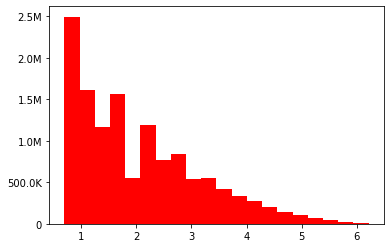

In [28]:
%%time

fig, ax = plt.subplots()
hist( ax
      , sDF_train5 \
          .groupBy('session').agg(  F.count('aid').alias('aid_cnt') ) \
          .withColumn( 'aid_cnt_log', F.log( F.col('aid_cnt') ) )
          .select('aid_cnt_log')
      , bins = 20
      , color=['red'])

CPU times: user 312 ms, sys: 27.3 ms, total: 339 ms
Wall time: 17.3 s


(array([7.50099e+05, 0.00000e+00, 2.94443e+05, 1.60436e+05, 1.01337e+05,
        1.19306e+05, 6.75510e+04, 5.84360e+04, 4.25040e+04, 3.17850e+04,
        1.99470e+04, 1.15880e+04, 6.95800e+03, 3.87800e+03, 1.98900e+03,
        8.92000e+02, 4.21000e+02, 1.57000e+02, 5.40000e+01, 2.20000e+01]),
 array([0.        , 0.30634346, 0.61268692, 0.91903038, 1.22537384,
        1.5317173 , 1.83806076, 2.14440421, 2.45074767, 2.75709113,
        3.06343459, 3.36977805, 3.67612151, 3.98246497, 4.28880843,
        4.59515189, 4.90149535, 5.20783881, 5.51418227, 5.82052572,
        6.12686918]),
 <a list of 20 Patch objects>)

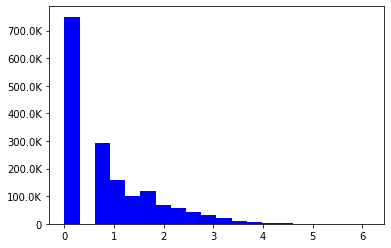

In [29]:
%%time

fig, ax = plt.subplots()
hist( ax
      , sDF_test5 \
          .groupBy('session').agg(  F.count('aid').alias('aid_cnt') ) \
          .withColumn( 'aid_cnt_log', F.log( F.col('aid_cnt') ) )
          .select('aid_cnt_log')
      , bins = 20
      , color=['blue'])

In [30]:
sDF_train6 = sDF_train5.withColumn( 'ts_dt', F.to_timestamp(F.col('ts')) )\
        .withColumn( 'ts_dt_year', F.year('ts_dt') )\
        .withColumn( 'ts_dt_month', F.month('ts_dt') )\
        .withColumn( 'ts_dt_dayofmonth', F.dayofmonth('ts_dt') )\
        .withColumn( 'ts_dt_dayofweek', F.dayofweek('ts_dt') )\
        .withColumn( 'ts_dt_hour', F.hour('ts_dt') )\
        .withColumn( 'ts_dt_minute', F.minute('ts_dt') )\
        .drop(F.col('ts'))

sDF_train6.show()

+-------+---+-------+----+-------------------+----------+-----------+----------------+---------------+----------+------------+
|session|pos|    aid|type|              ts_dt|ts_dt_year|ts_dt_month|ts_dt_dayofmonth|ts_dt_dayofweek|ts_dt_hour|ts_dt_minute|
+-------+---+-------+----+-------------------+----------+-----------+----------------+---------------+----------+------------+
|      0|  6|1649869|   1|2022-08-01 16:04:54|      2022|          8|               1|              2|        16|           4|
|      0|112|1443747|   0|2022-08-16 05:40:05|      2022|          8|              16|              3|         5|          40|
|      0|203| 974651|   1|2022-08-26 21:45:42|      2022|          8|              26|              6|        21|          45|
|      0|268| 543308|   0|2022-08-28 10:23:48|      2022|          8|              28|              1|        10|          23|
|      3| 16|1089061|   0|2022-08-01 21:51:20|      2022|          8|               1|              2|        2

In [31]:
sDF_test6 = sDF_test5.withColumn( 'ts_dt', F.to_timestamp(F.col('ts')) )\
        .withColumn( 'ts_dt_year', F.year('ts_dt') )\
        .withColumn( 'ts_dt_month', F.month('ts_dt') )\
        .withColumn( 'ts_dt_dayofmonth', F.dayofmonth('ts_dt') )\
        .withColumn( 'ts_dt_dayofweek', F.dayofweek('ts_dt') )\
        .withColumn( 'ts_dt_hour', F.hour('ts_dt') )\
        .withColumn( 'ts_dt_minute', F.minute('ts_dt') )\
        .drop(F.col('ts'))

sDF_test6.show()

+--------+---+-------+----+-------------------+----------+-----------+----------------+---------------+----------+------------+
| session|pos|    aid|type|              ts_dt|ts_dt_year|ts_dt_month|ts_dt_dayofmonth|ts_dt_dayofweek|ts_dt_hour|ts_dt_minute|
+--------+---+-------+----+-------------------+----------+-----------+----------------+---------------+----------+------------+
|12899789|  1| 631398|   0|2022-08-28 22:03:24|      2022|          8|              28|              1|        22|           3|
|12899791|  3|1365651|   0|2022-08-28 22:01:50|      2022|          8|              28|              1|        22|           1|
|12899793|  2|1792644|   0|2022-08-28 22:00:57|      2022|          8|              28|              1|        22|           0|
|12899832|  8|1509329|   0|2022-08-28 22:11:08|      2022|          8|              28|              1|        22|          11|
|12899842|  0|  46318|   0|2022-08-28 22:00:13|      2022|          8|              28|              1| 

In [32]:
%%time

train_ts_min = sDF_train6.select( F.min(F.col('ts_dt')) ).collect()[0][0]
train_ts_max = sDF_train6.select( F.max(F.col('ts_dt')) ).collect()[0][0]
print(f'Train: min={train_ts_min}, max={train_ts_max}')

test_ts_min = sDF_test6.select( F.min(F.col('ts_dt')) ).collect()[0][0]
test_ts_max = sDF_test6.select( F.max(F.col('ts_dt')) ).collect()[0][0]
print(f'Test: min={test_ts_min}, max={test_ts_max}')


Train: min=2022-07-31 22:00:00, max=2022-08-28 22:00:00
Test: min=2022-08-28 22:00:00, max=2022-09-04 21:59:52
CPU times: user 96.5 ms, sys: 9.38 ms, total: 106 ms
Wall time: 15.5 s


In [33]:
aids_train_list = sDF_train5\
                    .groupBy('aid').agg(  F.countDistinct('session').alias('session_cnt') )\
                    .rdd.map(lambda x: x[0])\
                    .collect()
                    
aids_test_list = sDF_test5\
                    .groupBy('aid').agg(  F.countDistinct('session').alias('session_cnt') )\
                    .rdd.map(lambda x: x[0])\
                    .collect()

print("""count aid's in Train:""", len(aids_train_list) )
print("""count aid's in Test:""", len(aids_test_list) )
print( """count aid's in Test and not in Train:"""
      , len( set(aids_test_list) - set(aids_train_list) ) )

count aid's in Train: 1855603
count aid's in Test: 783486
count aid's in Test and not in Train: 0


In [34]:
session_train = sDF_train5\
              .groupBy('session').agg(  F.countDistinct('aid').alias('aid_cnt') ) \
              .summary()
              
session_test = sDF_test5\
              .groupBy('session').agg(  F.countDistinct('aid').alias('aid_cnt') ) \
              .summary()

session_train.show()
session_test.show()

+-------+------------------+------------------+
|summary|           session|           aid_cnt|
+-------+------------------+------------------+
|  count|          12899779|          12899779|
|   mean|         6449889.0| 10.36326808389508|
| stddev|3723845.5834059077|18.985134421368777|
|    min|                 0|                 1|
|    25%|           3224540|                 2|
|    50%|           6449133|                 4|
|    75%|           9674023|                10|
|    max|          12899778|               486|
+-------+------------------+------------------+

+-------+------------------+------------------+
|summary|           session|           aid_cnt|
+-------+------------------+------------------+
|  count|           1671803|           1671803|
|   mean|        1.373568E7|2.9947051177680626|
| stddev|482608.10037855775| 5.113723026815698|
|    min|          12899779|                 1|
|    25%|          13317656|                 1|
|    50%|          13735556|           

In [35]:
print('Train session_id between 0 and 12899778')
print('Test session_id between 12899779 and 14571581')
print()
print('Train session_id not in Test session_id')
print('(Train + Test) session_id between 0 and 14571581')

Train session_id between 0 and 12899778
Test session_id between 12899779 and 14571581

Train session_id not in Test session_id
(Train + Test) session_id between 0 and 14571581


# Save Final Data

In [36]:
%%time

sDF_train7 = SaveReadParquet( sDF_train6.select(['type',
                          'session',
                          'pos',
                          'aid',
                          #'ts',
                          #'ts_dt',
                          #'ts_dt_year',
                          'ts_dt_month',
                          'ts_dt_dayofmonth',
                          'ts_dt_dayofweek',
                          'ts_dt_hour',
                          'ts_dt_minute'])
                    , f_name = 'sDF_train7'
                    , my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/'
                    )

sDF_train7.show()

/content/drive/MyDrive/Colab Notebooks/Kaggle/sDF_train7.parquet
+----+-------+---+-------+-----------+----------------+---------------+----------+------------+
|type|session|pos|    aid|ts_dt_month|ts_dt_dayofmonth|ts_dt_dayofweek|ts_dt_hour|ts_dt_minute|
+----+-------+---+-------+-----------+----------------+---------------+----------+------------+
|   1|      0|  6|1649869|          8|               1|              2|        16|           4|
|   0|      0|112|1443747|          8|              16|              3|         5|          40|
|   1|      0|203| 974651|          8|              26|              6|        21|          45|
|   0|      0|268| 543308|          8|              28|              1|        10|          23|
|   0|      3| 16|1089061|          8|               1|              2|        21|          51|
|   0|      6| 47|1479126|          8|               1|              2|        10|          33|
|   0|      6| 73|1747070|          8|               1|              2|

In [37]:
%%time

sDF_test7  = SaveReadParquet( sDF_test6.select(['type',
                          'session',
                          'pos',
                          'aid',
                          #'ts',
                          #'ts_dt',
                          #'ts_dt_year',
                          'ts_dt_month',
                          'ts_dt_dayofmonth',
                          'ts_dt_dayofweek',
                          'ts_dt_hour',
                          'ts_dt_minute'])
                    , f_name = 'sDF_test7'
                    , my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/'
                    )

sDF_test7.show()

/content/drive/MyDrive/Colab Notebooks/Kaggle/sDF_test7.parquet
+----+--------+---+-------+-----------+----------------+---------------+----------+------------+
|type| session|pos|    aid|ts_dt_month|ts_dt_dayofmonth|ts_dt_dayofweek|ts_dt_hour|ts_dt_minute|
+----+--------+---+-------+-----------+----------------+---------------+----------+------------+
|   0|12899789|  1| 631398|          8|              28|              1|        22|           3|
|   0|12899791|  3|1365651|          8|              28|              1|        22|           1|
|   0|12899793|  2|1792644|          8|              28|              1|        22|           0|
|   0|12899832|  8|1509329|          8|              28|              1|        22|          11|
|   0|12899842|  0|  46318|          8|              28|              1|        22|           0|
|   0|12899850| 98|1004556|          8|              29|              2|        16|          45|
|   0|12899852| 19| 701401|          8|              28|       

In [ ]:
# %%time

# # my_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/'
# my_dir = '/content/'

# sDF_train7 = spark.read.parquet( my_dir + 'sDF_train7.parquet' )
# sDF_test7 = spark.read.parquet( my_dir + 'sDF_test7.parquet' )

# sDF_train7.show()
# sDF_test7.show()